Run the cell below if you want to have output of the cells on their side
reload the page to get back to the default way.
You can edit background colors below (change the hex #RGB values)
Taken from:
https://github.com/jupyter/notebook/issues/2897#issuecomment-442959381

# Initialize
Import packages and functions. \
Initialize serial connection. To recconnect with arduino, just run this cell again. 

In [1]:
# Check for exsisting serial connections
try:
    sc.serial.close() # If serial connection exists, close it. 
except:
    pass

# To autoreload imported libraries:    
%load_ext autoreload
%autoreload 2

import logging
import time

import serial_connection

from my_funcs import *

def flush():
    """
    Flush input buffer of the serial by reading and printing its contetnts.
    
    There is a hardcoded limit on how many lines are read.
    """
    flag_buffer_empty = False
    print('... Flushing... ')
    for i in range(100):
        input_line = sc.readline()
        # print(input_line)
        if len(input_line) <= 0:
            print('... nothing more to flush.')
            flag_buffer_empty = True
            break
    if not flag_buffer_empty:
        print('!! There might still be data in the buffer. Try flushing again.')
    else: 
        print('... flushing successfull!')

    
# --- Init settings ------------------------------------------------------------    
# COM port to which Arduino is connected

#DAC1_port = 'COM24' # On the lab computer
# DAC1_port = 'COM8' 
ports = serial_ports()
print(f'Avaliable ports: {ports}')
for port in ports:
    if port.startswith('/dev/tty.usbmodem'):
        print(f'DAC1 port set to: {port}')
        DAC1_port = port # for Ursa's Mac


# Set the level of logging. (recommended: logging.INFO 
# for more output you can use: logging.DEBUG)
logging.basicConfig(level=logging.INFO)
# ------------------------------------------------------------------------------
    
# Start the serial connection
sc = serial_connection.serialConnection(port=DAC1_port, baud_rate=19200, string_terminator='\r')

# ### Settings on the Arduino
# scmd.addCommand("!TT", cmd_set_auto_timeout_time);  // _ #autoTimeoutTime
a = sc.send_string('!TT 200', wait_for_answer=False)
# scmd.addCommand("!TO", cmd_set_auto_timeout_on);    // _ #autoTimeoutOn (0 or 1)
a = sc.send_string('!TO 1', wait_for_answer=False)
# scmd.addCommand("!VM", cmd_set_voltage_max);        // _ #Vmax (in range 0 to 3000)
a = sc.send_string('!VM 2000', wait_for_answer=False)
# scmd.addCommand("!PA", cmd_setPrintAll);            // _ #printAll (0 or 1)
a = sc.send_string('!PA 0', wait_for_answer=False)

flush()    

Avaliable ports: ['/dev/tty.JBLTUNE230NCTWS', '/dev/tty.Bluetooth-Incoming-Port', '/dev/tty.usbmodem144201']
DAC1 port set to: /dev/tty.usbmodem144201


INFO:root:Serial opened on port /dev/tty.usbmodem144201 with baud rate 19200


... Flushing... 
... nothing more to flush.
... flushing successfull!


# Run experiment

In [10]:
import numpy as np 

recorded_time, set_voltage, measurements = multi_box(t_on=3, t_off=3, N_pulses=3, voltage_ampl=500, tip_idx=0,serial=sc)

Done


In [19]:
import numpy as np 

recorded_time, set_voltage, measurements = multi_box_ampl_variation(t_on=3, t_off=3, N_pulses=3, voltage_ampl=[500, 1500], tip_idx=0,serial=sc)

[500, 1000, 1500]
Done


In [8]:
# Working with one tip (tip number 0)
tip_idx = 0

import numpy as np

measurements = []
# --- User settings -------------------------------------------------------------------

mode = ['step', 'sine', 'box', 'my_func'][3]
voltage_amplitude = 1000 # Set voltage

t_on = 5

# my_func: several box functions with period and number of cycles
period = 20
N_cycles = 10

t_signal_start = 1
if mode == "my_func":
    t_recording_stop = t_signal_start + N_cycles*period + 3
else:   
    t_recording_stop = t_signal_start + t_on + 3

dT = 0.05 # Approximate time resolution (loop time)
# -------------------------------------------------------------------------------------

t_start = time.time()
timer_loop_time = time.time()

recorded_time = []
set_voltage = []
while time.time() < t_start + t_recording_stop:
    t = time.time() - t_start
    recorded_time.append(t)
    if mode == 'step':
        if  0 <= t - t_signal_start:
            voltage = voltage_amplitude
        else:
            voltage = 0
    elif mode == 'sine':
        if 0 <= t - t_signal_start <= t_on:
            voltage = int( 0.5*voltage_amplitude*(1 + np.sin(2*3.1415*2*t)) )
        else:
            voltage = 0
    elif mode == 'box':
        if 0 <= t - t_signal_start <= t_on:
            voltage = voltage_amplitude
        else:
            voltage = 0
    elif mode == 'my_func':
        if t > period*N_cycles:
            voltage = 0
        elif 0 <= t%period - t_signal_start <= t_on:
            voltage = voltage_amplitude
        else:
            voltage = 0
    
    else:
        print('mode undefined')
        break
    
    set_voltage.append(voltage)

    # Send control voltage to Arduino - Vin
    a = sc.send_string(f"!SI {tip_idx} " + str(voltage), wait_for_answer=True)
    VI = int(a.split(' ')[2])
    
    # Read the voltage measurement - Vsense
    a = sc.send_string(f'?SS {tip_idx}', wait_for_answer=True)
    VS = int(a.split(' ')[1])
    t = time.time() - t_start

    measurements.append([t, VI, VS])
    while time.time() < timer_loop_time + dT:
        time.sleep(0.0001)
    timer_loop_time = time.time()

print('Done')

KeyboardInterrupt: 

# Plot the measurements

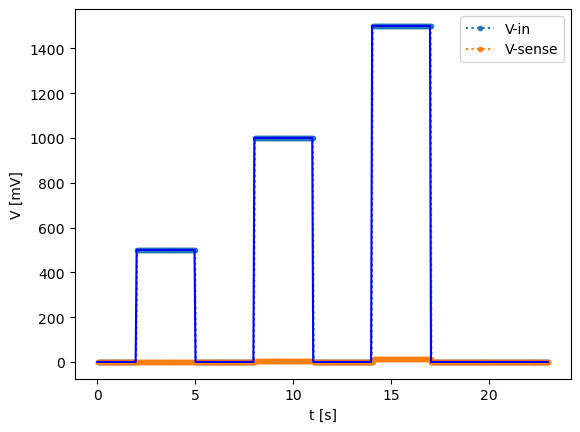

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
    
data = np.array(measurements)
fig = plt.figure()
fig.patch.set_facecolor('white')


plt.plot(data[:, 0], data[:, 1], ':.', label='V-in')
plt.plot(data[:, 0], data[:, 2], ':.', label='V-sense')
# Visual aids:
plt.plot(recorded_time, set_voltage, 'b-')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [mV]')
plt.show()


### Saving the measurements to a file

In [ ]:
# File counter is used for naming of saved files - it will overwrite saved files 
# when the same number.
file_counter = 0

In [ ]:
# # Save the data to text file
# folder = 'E:/data/Ursa/20221011_exp_w_Melissa/'

# #file_counter += 1
# #file_name = folder + 'voltage_timeseries_' + str(file_counter) + '.txt'
# file_name = folder + "20221011_exp_w_Melissa/221011_sample1B_14_49_500mV/" + "voltage.txt'"

# comment = input('Enter the comment for the saved file:')
# header_text = 't[s] Vin[mV] Vsense[mV]    comment: ' + comment
file_name = "E:/data/Ursa/20221011_exp_w_Melissa/221011_sample1A_15_20_2000_mV_60x/voltage.txt"
np.savetxt(file_name, data)
print('File saved. Name:', file_name)


# Functions for debugging
Should be moved to other files or integrated into source scripts at some point.

In [5]:
"""To get the list of serial ports"""
import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


print('Available serial ports:')
print(serial_ports())


Available serial ports:
['/dev/tty.JBLTUNE230NCTWS', '/dev/tty.Bluetooth-Incoming-Port', '/dev/tty.usbmodem144301']
